# Dimensionality reduction on colonoscopy video data 

Machine learning is becoming more successful in many medical applications, especially in analyzing image or video data. The field of proctology is no exception. I find this example particularly interesting as one of my best friends has to get regular colonoscopies as a measure of colon cancer prophylactics and I'd like to tell her if machine learning can assist the doctors in classifying whatever they find in her behind as benign or malignant.

This data set contains 76 instances of gastrointestinal lesions, two malignant and one benign type, from regular colonoscopy data. It was contributed to the [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets/Gastrointestinal+Lesions+in+Regular+Colonoscopy) by Pablo Mesejo and Daniel Pizarro. You can find a detailed description on the website. They also provided a summary of how human experts performed on classifying the examples.

## Frame the Problem
In this example, we want to classify each lesions as either serrated adenomas, adenoma, or hyperplastic lesion. The first two are considered malignant, the latter as benign. Hence, we can also treat it as a binary classification problem (the authors of the data set labeled this binary case as *resection* vs. *no-resection*). 

What is special about this data set is that we are dealing with a lot of features but only a few instances. From each video, there are 422 2D textural features, 76 2D color features, 200 3D shape features, and each of those recorded under two different light conditions. A total of 1397 features and only 76 instances. Most classification algorithms will have problems with this ratio. Support vector machines are known for being able to deal with many features given few instances, but this ratio might be too extreme even for them. So what can we do about it? 

In this example we will try to apply principal component analysis (PCA) to reduce the dimensionality of the feature space while still preserving much information of the original data. PCA will project the original high-dimensional data on a lower dimensional hyperplane (which is spanned by the principal components). We can either specify a number of dimensions and pick the PCs that preserve the most variance or we specify ho much variance should be preserved and pick the number of PCs accordingly. 

I would usually chose recall as optimization metric because I think it is important to not miss potential cancer; but since we want to compare to human performance (who probably want to get all classifications right) and we have a class imbalance, I'll choose the F1 score.

In [1]:
# import libraries 
import numpy as np # numerical computation
import pandas as pd # data handling
import warnings
warnings.filterwarnings('ignore')
# visulalization
import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set_style("darkgrid")
%matplotlib notebook

## Data preparation
Let's import the data into data frame hand have a look.

In [2]:
colon = pd.read_csv("data.txt")
colon.head()

,adenoma_1,adenoma_1.1,adenoma_8,adenoma_8.1,adenoma_9,adenoma_9.1,adenoma_10,adenoma_10.1,adenoma_11,adenoma_11.1,...,serrated_5,serrated_5.1,serrated_6,serrated_6.1,serrated_7,serrated_7.1,serrated_8,serrated_8.1,serrated_9,serrated_9.1
0,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
1,1.000000,2.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000,2.000000,1.000000,...,1.000000,2.000000,1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,1.000000,2.000000
2,138.120000,127.990000,80.415000,90.896000,106.160000,147.090000,148.730000,126.050000,109.130000,129.700000,...,114.590000,86.424000,163.680000,71.638000,180.110000,136.550000,96.852000,157.810000,93.569000,95.543000
3,1606.800000,3377.900000,1852.100000,1904.300000,1184.400000,822.320000,2412.500000,4752.200000,999.390000,599.950000,...,3014.500000,3500.900000,3253.100000,1822.200000,1198.500000,1316.300000,2071.300000,2732.300000,1163.600000,2240.500000
4,0.003875,0.003564,0.004761,0.004147,0.005518,0.003871,0.003336,0.004188,0.005541,0.005917,...,0.004444,0.003409,0.004869,0.004148,0.003273,0.002442,0.004379,0.004015,0.002199,0.004803


In this raw format, each column represents an instance measured at one of the two different light conditions, and the rows represents a features. The first row is the class label and the second row the light condition (1 or 2). We'll first have to merge the two light conditions per instance and than transpose the data frame so that we have the data in a [tidy format](https://vita.had.co.nz/papers/tidy-data.pdf#targetText=This%20paper%20tackles%20a%20small,observational%20unit%20is%20a%20table.).

In [3]:
# get the column names for light conditions 1 and 2
light1cols = colon.loc[1,colon.iloc[1]==1].index
light2cols = colon.loc[1,colon.iloc[1]==2].index
# create seperate data frames for the two conditions
light1 = colon[light1cols]
light2 = colon[light2cols]
# give them the same column names so that they can be appended 
light2.columns = light1.columns
# append data frame while dropping the light condtion and class label from one of them
colon = light1.append(light2.iloc[2:])
# drop the light condition from the other one
colon = colon.drop(1,axis=0).reset_index(drop=True)
# transpose the data frame so that instances are rows and features are columns
colon = colon.T.reset_index(drop=True).rename(columns={0:"label"})

In [4]:
colon.head()

,label,1,2,3,4,5,6,7,8,9,...,1387,1388,1389,1390,1391,1392,1393,1394,1395,1396
0,3.0,138.120,1606.80,0.003875,0.005880,0.005213,0.006935,0.007333,0.009580,0.007380,...,0.013994,0.013532,0.013157,0.012743,0.012613,0.012422,0.012252,0.011377,0.011198,0.011131
1,3.0,90.896,1904.30,0.004147,0.006728,0.005061,0.006879,0.007948,0.009525,0.010492,...,0.003564,0.003380,0.003232,0.003200,0.003006,0.002985,0.002922,0.002631,0.002610,0.002531
2,3.0,147.090,822.32,0.003871,0.005211,0.005834,0.006971,0.011036,0.012802,0.011083,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,3.0,148.730,2412.50,0.003336,0.007695,0.004139,0.005736,0.005794,0.006697,0.007721,...,0.020822,0.020115,0.019595,0.019252,0.018897,0.018177,0.018158,0.017587,0.017109,0.016648
4,3.0,129.700,599.95,0.005917,0.007934,0.006976,0.007695,0.008404,0.008825,0.010306,...,0.000140,0.000129,0.000117,0.000111,0.000106,0.000098,0.000093,0.000082,0.000079,0.000076


Now that looks a lot tidier. Let's also change the class labels: 1 becomes 0 for benign; 2 and 3 become 1 for malignant. 

In [5]:
colon.label[colon.label==1] = 0
colon.label[(colon.label==2) | (colon.label==3)] = 1
colon.sample(5)

,label,1,2,3,4,5,6,7,8,9,...,1387,1388,1389,1390,1391,1392,1393,1394,1395,1396
9,1.0,127.47,1406.80,0.002802,0.004276,0.003806,0.005146,0.005410,0.006105,0.007818,...,0.003110,0.003053,0.002898,0.002774,0.002632,0.002493,0.002450,0.002312,0.002179,0.002090
40,0.0,140.73,711.59,0.006186,0.009827,0.006869,0.009844,0.010494,0.012854,0.012929,...,0.000002,0.000002,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001
36,1.0,163.11,1385.90,0.008264,0.011529,0.006550,0.007291,0.012066,0.013678,0.015943,...,0.000050,0.000048,0.000046,0.000046,0.000044,0.000039,0.000033,0.000032,0.000030,0.000027
47,0.0,154.63,566.70,0.005386,0.008225,0.006184,0.008711,0.006867,0.008170,0.013066,...,0.000005,0.000005,0.000005,0.000004,0.000004,0.000004,0.000003,0.000003,0.000003,0.000003
22,1.0,158.80,3795.40,0.005593,0.010721,0.009279,0.011931,0.014284,0.013749,0.018370,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [6]:
# look for missing values
colon.isna().sum()[colon.isna().sum()>0]

Series([], dtype: int64)

In [7]:
# look at class distribution
colon.label.value_counts()

1.0    55
0.0    21
Name: label, dtype: int64

Looks like we don't have to clean the data anymore. We should now split off our test set.

In [8]:
from sklearn.model_selection import StratifiedShuffleSplit
# put 20%  of the data aside as a test set
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1234)
for train_index, test_index in split.split(colon, colon["label"]):
    colon_train = colon.loc[train_index]
    colon_test = colon.loc[test_index]
    X_train = colon_train.iloc[:,1:]
    y_train = colon_train.loc[:,"label"]
    X_test = colon_test.iloc[:,1:]
    y_test = colon_test.loc[:,"label"]


## Selecting and tuning models
Let's try to get a base line first by training an SVC model with all the features and no preprocessing besides standard scaling. We can than compare the performance of the lower dimensionality models with this benchmark.

In [9]:
# import all sklearn functions needed
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

# put a standard scaler and a support vector calssifier in a pipeline
pipe = Pipeline(steps=[
               ("scaler",StandardScaler()),
               ("svc",SVC(class_weight="balanced"))])

# define paramter space to search durring grid search
param_grid = {"svc__kernel":["linear","rbf"],
              "svc__C":np.logspace(-6,4,5),
              "svc__gamma":np.logspace(-8,1,5)}

# perform grid search
grid = GridSearchCV(pipe, param_grid=param_grid,
                    n_jobs=-1, cv=6, scoring="f1",
                    iid=False, verbose=0)
grid.fit(X_train,y_train)

print("Cross validation Grid search:")
print("Best parameter (CV F1 score=%0.3f):" % grid.best_score_)
print(grid.best_params_)

print("\nPerformance on the test set:\n")
print("Confusion matrix:")
y_pred = grid.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print("F1: {:0.3f}".format(f1_score(y_test, y_pred)))
print("Recall: {:0.3f}".format(recall_score(y_test, y_pred)))
print("Precision: {:0.3f}".format(precision_score(y_test, y_pred)))
print("Accuracy: {:0.3f}".format(accuracy_score(y_test, y_pred)))

Cross validation Grid search:
Best parameter (CV F1 score=0.880):
{'svc__C': 0.1, 'svc__gamma': 1e-08, 'svc__kernel': 'linear'}

Performance on the test set:

Confusion matrix:
[[ 4  0]
 [ 2 10]]
F1: 0.909
Recall: 0.833
Precision: 1.000
Accuracy: 0.875


We actually perform already very well without any fancy preprocessing, already beating the human experts who's binary classification accuracy is around 0.796. But we still have a few false negatives in our test set classification which can be a severe problem for malignant tumors. If a patient is told that they're fine, the tumor may get a lot worse until they notice that the diagnosis was wrong. Maybe we can improve our benchmark results.

Let's start with a simple PCA with only two PCs so that we can plot our data points 

In [10]:
from sklearn.decomposition import PCA
# do a PCA with 2 PCs
# Note: the infput data is centred aroud 0 automatically before the PCA,
# the whiten parameter scales the output to unit variance, so it basically acts
# like a standard scaler
pca = PCA(n_components=2, whiten=True)
X_train_pca = pca.fit_transform(X_train)
print("Variance explained by the first two PCs: {:0.3f}".format(sum(pca.explained_variance_ratio_)))

Variance explained by the first two PCs: 0.921


Wow! 92% of the original training data is preserved when projecting it from 1396 dimensions to only two dimensions. Lets plot it: 

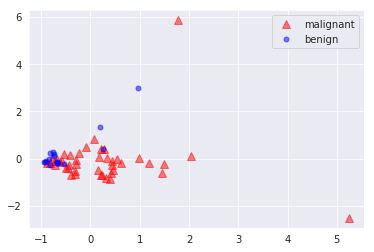

In [11]:
# split instances into malignant and benign
idx_b = np.argwhere(y_train==0).reshape(1,-1)
idx_m = np.argwhere(y_train==1).reshape(1,-1)
malignant = X_train_pca[idx_m].reshape(-1,2)
benign = X_train_pca[idx_b].reshape(-1,2)

# plot on a scatter plot
plt.plot(malignant[:,0],malignant[:,1],"^r",label="malignant",ms=8,alpha=.5)
plt.plot(benign[:,0],benign[:,1],".b",label="benign",ms=10,alpha=.5)
_ = plt.legend()

We can see that benign and malignant lesions tend to different regions of the figure but there i some significant overlap of points which would probably hard to deconvolve. Maybe we've lost too much of the original data's information and we should chose the number of PCs according to how much variance we want to preserve. We can specify that percentage instead the number of PCs.

In [12]:
# do a PCA preserving 0.95 of the original data's variance
var = 0.95
pca = PCA(n_components=var)
X_train_pca = pca.fit_transform(X_train)
n_comp = len(pca.components_)
print("Preserving {} variance requires {} PCs.".format(var,n_comp))

Preserving 0.95 variance requires 3 PCs.


In [13]:
# do a PCA preserving 0.99 of the original data's variance
var = 0.99
pca = PCA(n_components=var)
X_train_pca = pca.fit_transform(X_train)
n_comp = len(pca.components_)
print("Preserving {} variance requires {} PCs.".format(var,n_comp))

Preserving 0.99 variance requires 6 PCs.


In [14]:
# do a PCA preserving 0.999 of the original data's variance
var = 0.999
pca = PCA(n_components=var)
X_train_pca = pca.fit_transform(X_train)
n_comp = len(pca.components_)
print("Preserving {} variance requires {} PCs.".format(var,n_comp))

Preserving 0.999 variance requires 11 PCs.


The amount of preserved variance can be used as a hyper-parameter in a grid search.

In [15]:
# put a standard-scaled PCA and a support vector calssifier in a pipeline
pipe = Pipeline(steps=[
               ("pca",PCA(whiten=True)),
               ("svc",SVC(kernel="linear",class_weight="balanced"))])

# define paramter space to search durring grid search
param_grid = {"svc__C":np.logspace(-4,6,5),
              "pca__n_components":[0.95,0.99,0.999]}

# perform grid search
grid = GridSearchCV(pipe, param_grid=param_grid,
                    n_jobs=-1, cv=6, scoring="f1",
                    iid=False, verbose=0)
grid.fit(X_train,y_train)

print("Cross validation Grid search:")
print("Best parameter (CV F1 score=%0.3f):" % grid.best_score_)
print(grid.best_params_)

print("\nPerformance on the test set:\n")
print("Confusion matrix:")
y_pred = grid.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print("F1: {:0.3f}".format(f1_score(y_test, y_pred)))
print("Recall: {:0.3f}".format(recall_score(y_test, y_pred)))
print("Precision: {:0.3f}".format(precision_score(y_test, y_pred)))
print("Accuracy: {:0.3f}".format(accuracy_score(y_test, y_pred)))

Cross validation Grid search:
Best parameter (CV F1 score=0.916):
{'pca__n_components': 0.999, 'svc__C': 3162.2776601683795}

Performance on the test set:

Confusion matrix:
[[ 4  0]
 [ 2 10]]
F1: 0.909
Recall: 0.833
Precision: 1.000
Accuracy: 0.875


The cross-validation score was slightly improved, but in our test set there are still two instances misclassified. There is a version of kernel PCA (which basically employs the kernel trick like support vector machines) which allows it to perform nonlinear projections for dimensionality reduction. Let's see if we can improve our results with kernel PCA. Unfortunately we can not directly specify the amount of variance we want to preserve, so we'll have to calculate manually how many components will be needed for a certain desired preserved variance given a certain kernel (e.g. linear, rbf, polynomial, cosine, using default parameters).

In [16]:
from sklearn.decomposition import KernelPCA

# set up a kPCA with linear kernel and calculate all PCs
kpca = KernelPCA(kernel="linear")
X_train_kpca = kpca.fit_transform(X_train)
# calculate the explained variance
explained_variance = np.var(X_train_kpca, axis=0)
explained_variance_ratio = explained_variance / np.sum(explained_variance)
cumsum = np.cumsum(explained_variance_ratio)
# print results
print("For kPCA with linear kernel:")
for v in [0.95,0.99,0.999]:
    for i,c in enumerate(cumsum):
        if c>v:
            print("Preserving {} variance requires {} PCs.".format(v,i+1))
            break

For kPCA with linear kernel:
Preserving 0.95 variance requires 3 PCs.
Preserving 0.99 variance requires 6 PCs.
Preserving 0.999 variance requires 11 PCs.


In [17]:
# set up a kPCA with rbf kernel and calculate all PCs
kpca = KernelPCA(kernel="rbf")
X_train_kpca = kpca.fit_transform(X_train)
# calculate the explained variance
explained_variance = np.var(X_train_kpca, axis=0)
explained_variance_ratio = explained_variance / np.sum(explained_variance)
cumsum = np.cumsum(explained_variance_ratio)
# print results
print("For kPCA with rbf kernel:")
for v in [0.95,0.99,0.999]:
    for i,c in enumerate(cumsum):
        if c>v:
            print("Preserving {} variance requires {} PCs.".format(v,i+1))
            break

For kPCA with rbf kernel:
Preserving 0.95 variance requires 57 PCs.
Preserving 0.99 variance requires 59 PCs.
Preserving 0.999 variance requires 59 PCs.


In [18]:
# set up a kPCA with polynomial kernel and calculate all PCs
kpca = KernelPCA(kernel="poly")
X_train_kpca = kpca.fit_transform(X_train)
# calculate the explained variance
explained_variance = np.var(X_train_kpca, axis=0)
explained_variance_ratio = explained_variance / np.sum(explained_variance)
cumsum = np.cumsum(explained_variance_ratio)
# print results
print("For kPCA with polynomial kernel:")
for v in [0.95,0.99,0.999]:
    for i,c in enumerate(cumsum):
        if c>v:
            print("Preserving {} variance requires {} PCs.".format(v,i+1))
            break

For kPCA with polynomial kernel:
Preserving 0.95 variance requires 1 PCs.
Preserving 0.99 variance requires 2 PCs.
Preserving 0.999 variance requires 4 PCs.


In [19]:
# set up a kPCA with cosine kernel and calculate all PCs
kpca = KernelPCA(kernel="cosine")
X_train_kpca = kpca.fit_transform(X_train)
# calculate the explained variance
explained_variance = np.var(X_train_kpca, axis=0)
explained_variance_ratio = explained_variance / np.sum(explained_variance)
cumsum = np.cumsum(explained_variance_ratio)
# print results
print("For kPCA with cosine kernel:")
for v in [0.95,0.99,0.999]:
    for i,c in enumerate(cumsum):
        if c>v:
            print("Preserving {} variance requires {} PCs.".format(v,i+1))
            break

For kPCA with cosine kernel:
Preserving 0.95 variance requires 8 PCs.
Preserving 0.99 variance requires 12 PCs.
Preserving 0.999 variance requires 18 PCs.


If we want to use both the kernel type and the preserved variance level in hyper-parameter tuning, we should write our own transformer class which handles that easily.

In [20]:
from sklearn.base import BaseEstimator, TransformerMixin

class kPCA(BaseEstimator, TransformerMixin):
    """This class allows to tune kernel-type and variance-to-preserve as hyper-paramters"""
    
    pc_dict = {"linear":{0.95:3,0.99:6,0.999:11},
               "rbf":{0.95:57,0.99:59,0.999:59},
               "poly":{0.95:1,0.99:2,0.999:4},
               "cosine":{0.95:8,0.99:12,0.999:18}}
    
    def __init__(self, kernel="linear", var=0.95):
        self.kernel = kernel
        self.var = var
        self.kpca = KernelPCA(kernel=self.kernel,
                              n_components=self.pc_dict[kernel][var])
        
    def fit(self, X, y=None):
        self.kpca.fit(X)
        return self
    
    def transform(self, X, y=None):
        return self.kpca.transform(X)

Let's see if we can up our performance in a final grid search with different kernel PCAs.

In [23]:
# put the custom kPCA, a standard scaler, and a support vector calssifier in a pipeline
pipe = Pipeline(steps=[
               ("kpca",kPCA()),
               ("scaler", StandardScaler()),
               ("svc",SVC(kernel="linear",class_weight="balanced"))])

# define paramter space to search durring grid search
param_grid = {"kpca__kernel":["linear","rbf","poly","cosine"],
              "kpca__var":[0.95,0.99,0.999],
              "svc__C":np.logspace(-6,6,4)}

# perform grid search
grid = GridSearchCV(pipe, param_grid=param_grid,
                    n_jobs=-1, cv=6, scoring="f1",
                    iid=False, verbose=0)
grid.fit(X_train,y_train)

print("Cross validation Grid search:")
print("Best parameter (CV F1 score=%0.3f):" % grid.best_score_)
print(grid.best_params_)

print("\nPerformance on the test set:\n")
print("Confusion matrix:")
y_pred = grid.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print("F1: {:0.3f}".format(f1_score(y_test, y_pred)))
print("Recall: {:0.3f}".format(recall_score(y_test, y_pred)))
print("Precision: {:0.3f}".format(precision_score(y_test, y_pred)))
print("Accuracy: {:0.3f}".format(accuracy_score(y_test, y_pred)))

Cross validation Grid search:
Best parameter (CV F1 score=0.870):
{'kpca__kernel': 'linear', 'kpca__var': 0.95, 'svc__C': 100.0}

Performance on the test set:

Confusion matrix:
[[ 4  0]
 [ 2 10]]
F1: 0.909
Recall: 0.833
Precision: 1.000
Accuracy: 0.875


Well, looks like we weren't really able to achieve much of an improvement by dimensionality reduction but we also didn't make it worse. That means that the information that is in the data was as easy to grasp for the algorithm in higher dimensional space as in dimensionality reduced space. We do gain one big advantage through dimensionality reduction though: Significantly less computational cost! For this example with only 76 instances this may not seem relevant, but for much larger data sets it will be a massive speed-up if we can reduce the number of features from hundreds to only about a dozen without sacrificing too much classification accuracy (or what ever score we use).

Thanks a lot for following along through this example!